# Init

In [5]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path + "/src")
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\new-peak-project\src


In [6]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [7]:
new_path = config["NEW_DATA_PATH"]
print(f'New data path set to: {new_path}')

New data path set to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project


# Config

In [12]:
from models.utils.config_manager import initialise_config

initialise_config(folder_name="distortion-analysis", verbose=1)


Folder I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\distortion-analysis already exists. No changes made.


In [13]:
# or load existing config
from models.utils.config_manager import load_configs, print_config

loaded_config = load_configs(folder_name="distortion-analysis", config_suffix="E3R")
print_config(loaded_config)

notebook: 
  version: E3R
  name: distortion-analysis
  compatible_notebooks: ['distortion-analysis']
  desc: The E3R system using almost no param range but with distortion factor 

exp: 
  spec: 
    n_layers: 2
    n_cascades: 3
    n_regs: 3
    gen_seed: 42
    drug: 
      name: D
      start: 500
      dose: 500
      regulations: []
      target_all: True
  parameter_generation: 
    ic_range: [200, 1000]
    param_range: [0.5, 1.5]
    param_mul_range: [0.99, 1.01]
  feature_generation: 
    include_parameters: False
    excluded_layers: ['O']
  simulation: 
    start: 0
    stop: 1000
    step: 100
  dynamic_data: 
    exclude_activated_form: False
    excluded_layers: []
    distortion: True
    distortion_factor: 2
  machine_learning: 
    ml_seed: 42
    outcome_var: Oa
    n_samples: 1000
    n_reps: 10
  distortion_range: [1.1, 1.2, 1.3, 1.4, 1.5, 2, 4, 8, 16, 32]


# Run

In [14]:
from models.Specs.ModelSpec3 import ModelSpec3

notebook_config = loaded_config["notebook"]
exp_config = loaded_config["exp"]
spec_config = exp_config["spec"]
n_layers = spec_config["n_layers"]
new_spec = ModelSpec3(num_intermediate_layers=n_layers)


In [14]:
import logging
from models.Specs.Drug import Drug
logging.basicConfig(level=logging.INFO)


drug_config = spec_config['drug']
drug_name = drug_config['name']
drug_start = drug_config['start']
drug_dose = drug_config['dose']
drug_regulations = drug_config['regulations']

n_cascades = spec_config["n_cascades"]
n_regs = spec_config["n_regs"]
seed = spec_config["gen_seed"]

new_drug = Drug(name=drug_name, start_time=drug_start, default_value=drug_dose)

# check if target_all exists in drug_config, if not set to False
drug_target_all = drug_config.get('target_all', False)

if drug_target_all:
    # If the drug targets all receptors, we don't need to add specific regulations
    for n in range(n_cascades):
        target = f'R{n+1}' # assuming receptors are named R1, R2, ..., Rn
        new_drug.add_regulation(target, 'down') # assuming the type is 'down' for all
else: 
    for regs in drug_regulations:
        target, type = regs[0], regs[1]
        new_drug.add_regulation(target, type)

new_spec.generate_specifications(n_cascades, n_regs, seed)
new_spec.add_drug(new_drug)

In [15]:
from numpy.random import SeedSequence

param_gen_config = exp_config['parameter_generation']
specie_range = param_gen_config['ic_range']
param_range = param_gen_config['param_range']
param_mul_range = param_gen_config['param_mul_range']
n_samples = exp_config['machine_learning']['n_samples']

# base build 
builder_base = new_spec.generate_network('base', specie_range, param_range, param_mul_range, seed)
params_base = builder_base.get_parameters()
states_base = builder_base.get_state_variables()

ss = SeedSequence(seed)
build_seeds = []
for i in range(n_samples):
    child_ss = ss.spawn(1)[0]
    build_seeds.append(child_ss.generate_state(1)[0])

parameter_sets = []
all_builds = []
for seed in build_seeds:
    builder = new_spec.generate_network(str(seed), specie_range, param_range, param_mul_range, seed)
    parameter_sets.append(builder.get_parameters())
    all_builds.append(builder)

INFO:models.Specs.ModelSpec3:Generated model base with 20 reactions.
INFO:models.Specs.ModelSpec3:Model States: 20
INFO:models.Specs.ModelSpec3:Model Parameters: 55
INFO:models.Specs.ModelSpec3:Model Reactions: 20
INFO:models.Specs.ModelSpec3:Generated model 2684470948 with 20 reactions.
INFO:models.Specs.ModelSpec3:Model States: 20
INFO:models.Specs.ModelSpec3:Model Parameters: 55
INFO:models.Specs.ModelSpec3:Model Reactions: 20
INFO:models.Specs.ModelSpec3:Generated model 4091952314 with 20 reactions.
INFO:models.Specs.ModelSpec3:Model States: 20
INFO:models.Specs.ModelSpec3:Model Parameters: 55
INFO:models.Specs.ModelSpec3:Model Reactions: 20
INFO:models.Specs.ModelSpec3:Generated model 233227757 with 20 reactions.
INFO:models.Specs.ModelSpec3:Model States: 20
INFO:models.Specs.ModelSpec3:Model Parameters: 55
INFO:models.Specs.ModelSpec3:Model Reactions: 20
INFO:models.Specs.ModelSpec3:Generated model 3276785861 with 20 reactions.
INFO:models.Specs.ModelSpec3:Model States: 20
INFO:m

In [16]:
from models.Solver.RoadrunnerSolver import RoadrunnerSolver

solver = RoadrunnerSolver()
solver.compile(builder_base.get_sbml_model())


In [17]:
from models.SyntheticGen import generate_feature_data_v3, generate_target_data_diff_build

sim_config = exp_config["simulation"]
sim_start = sim_config["start"]
sim_stop = sim_config["stop"]
sim_step = sim_config["step"]
n_samples = exp_config["machine_learning"]["n_samples"]
ic_range = exp_config["parameter_generation"]["ic_range"]

feature_config = exp_config["feature_generation"]
excluded_layers = feature_config["excluded_layers"]

initial_values = builder.get_state_variables()
initial_values = {k: v for k, v in initial_values.items() if not k.endswith('a')} # should not perturb activated forms

if excluded_layers:
    for layer in excluded_layers:
        initial_values = {k: v for k, v in initial_values.items() if not k.startswith(f'{layer}')}

feature_data = generate_feature_data_v3(new_spec, initial_values, 'lhs', {'min': ic_range[0], 'max': ic_range[1]}, n_samples, seed)

sim_params = {
    'start': sim_start,
    'end': sim_stop,
    'points': sim_step
}

target_data, timecourse_data = generate_target_data_diff_build(new_spec, solver, feature_data, parameter_sets, sim_params, 
                                                               outcome_var='Oa', verbose=True)

Simulating perturbations: 100%|██████████| 1000/1000 [00:05<00:00, 171.58it/s]


In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# distortion
from numpy.random import default_rng
from models.SyntheticGen import generate_model_timecourse_data_diff_build_v3
from models.utils.dynamic_calculations import dynamic_features_method, last_time_point_method
from models.utils.config_manager import save_data


distortion_range = exp_config["distortion_range"]
output_data = []
for j, dis_factor in enumerate(distortion_range):
    
    dynamic_data_config = exp_config['dynamic_data']
    distortion = True

    modified_parameter_sets = []
    if distortion:
        print(f"Applying distortion to parameters... {dis_factor}")
        distortion_factor = dis_factor
        distort_range = (1 / distortion_factor, distortion_factor)

        rng = default_rng(seed)
        modified_parameter_sets = []
        for params in parameter_sets:
            new_params = {}
            for key, value in params.items():
                new_params[key] = (
                    value * rng.uniform(distort_range[0], distort_range[1])
                )  # distortion range, expectation is that the larger the worse the model performance
            modified_parameter_sets.append(new_params)
    else: 
        modified_parameter_sets = parameter_sets

    # generate the timecourse data for the new model
    distorted_timecourse = generate_model_timecourse_data_diff_build_v3(
        states_base,
        solver,
        feature_data,
        modified_parameter_sets,
        sim_params,
        capture_species="all",
        n_cores=1,
        verbose=True,
    )
    
    excluded_layers = dynamic_data_config["excluded_layers"]
    exclude_active_form = dynamic_data_config["exclude_activated_form"]
    initial_values = builder.get_state_variables()
    if exclude_active_form:
        initial_values = {k: v for k, v in initial_values.items() if not k.endswith('a')} # should not perturb activated forms
    if excluded_layers:
        for layer in excluded_layers:
            initial_values = {k: v for k, v in initial_values.items() if not k.startswith(f'{layer}')}

    last_time_data = last_time_point_method(distorted_timecourse, initial_values.keys())
    dynamic_data = dynamic_features_method(distorted_timecourse, initial_values.keys(), n_cores=4)

    
    combined_lp_data = pd.concat([feature_data, last_time_data], axis=1)
    combined_dyn_data = pd.concat([feature_data, dynamic_data], axis=1)
    feature_data_list = [feature_data, last_time_data, dynamic_data, combined_lp_data, combined_dyn_data]
    feature_data_names = ['feature_data', 'last_time_data', 'dynamic_data', 'combined_lp_data', 'combined_dyn_data']

    ml_seed = exp_config['machine_learning']['ml_seed']
    outcome_var = exp_config['machine_learning']['outcome_var']
    n_reps = exp_config['machine_learning']['n_reps']

    def evaluate_model(model, model_name, feature_data, feature_data_name, target_data, test_size=0.2, random_state=4):
        X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=test_size, random_state=random_state)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # return a dictionary of the model performance
        return {'Model': model_name, 
                'Feature Data': feature_data_name,
                'Mean Squared Error': mean_squared_error(y_test, y_pred),
                'R2 Score': r2_score(y_test, y_pred),
                'Pearson Correlation': pearsonr(y_test, y_pred)[0],
                'Pearson P-Value': pearsonr(y_test, y_pred)[1]
                }
    # create a linear regression model
    lm = LinearRegression()
    # create a random forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=ml_seed)
    # create a gradient boosting model
    gb = GradientBoostingRegressor(n_estimators=100, random_state=ml_seed)
    # create a support vector machine model
    svr = SVR(max_iter=10000)
    scaled_svr = Pipeline([('scaler', StandardScaler()), ('svr', svr)])
    # create a neural network model (simple)
    nn = MLPRegressor(hidden_layer_sizes=(20,), max_iter=10000, random_state=ml_seed)
    scaled_nn = Pipeline([('scaler', StandardScaler()), ('nn', nn)])

    all_models = [lm, rf, gb, scaled_svr, scaled_nn]
    all_models_desc = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
    zipped_model_data = list(zip(all_models, all_models_desc))
    all_features = feature_data_list
    all_features_desc = feature_data_names
    zipped_feature_data = list(zip(all_features, all_features_desc))

    # random states are rand ints between 0 and 10000, for n values 
    np.random.seed(ml_seed)
    n_random = n_reps
    all_random_states = np.random.randint(0, 10000, n_random)

    parallelise = True 
    # tqdm is a progress bar library, use it to show the progress of the model evaluation
    metric_data = []
    if not parallelise:          
        for (feature_data, feature_data_name) in tqdm(zipped_feature_data):
            # print('Feature Data:', feature_data_name)
            # print('Feature Data Shape:', feature_data.shape)
            for (model, model_name) in zipped_model_data:
                # print('Model:', model_name)
                for rand in all_random_states:
                    metrics = evaluate_model(model, model_name, feature_data, feature_data_name, target_data[outcome_var], random_state=rand)
                    metric_data.append(metrics)
                    
    else:        
        # parallelise the model evaluation process using joblib
        from joblib import Parallel, delayed

        metric_data = Parallel(n_jobs=-1)(delayed(evaluate_model)(model, model_name, feature_data, feature_data_name, target_data[outcome_var], random_state=rand) 
                                        for (feature_data, feature_data_name) in zipped_feature_data
                                        for (model, model_name) in zipped_model_data
                                        for rand in all_random_states)

    # make a dataframe of the metric data
    metric_df = pd.DataFrame(metric_data)
    metric_df['Distortion Factor'] = dis_factor
    output_data.append(metric_df)
    


Applying distortion to parameters... 1.1


Simulating perturbations: 100%|██████████| 1000/1000 [00:06<00:00, 156.48it/s]


Applying distortion to parameters... 1.2


Simulating perturbations: 100%|██████████| 1000/1000 [00:06<00:00, 156.48it/s]


Applying distortion to parameters... 1.3


Simulating perturbations: 100%|██████████| 1000/1000 [00:06<00:00, 160.38it/s]


Applying distortion to parameters... 1.4


Simulating perturbations: 100%|██████████| 1000/1000 [00:06<00:00, 152.95it/s]


Applying distortion to parameters... 1.5


Simulating perturbations: 100%|██████████| 1000/1000 [00:06<00:00, 159.45it/s]


Applying distortion to parameters... 2


Simulating perturbations: 100%|██████████| 1000/1000 [00:06<00:00, 159.55it/s]


Applying distortion to parameters... 4


Simulating perturbations: 100%|██████████| 1000/1000 [00:06<00:00, 156.86it/s]


Applying distortion to parameters... 8


Simulating perturbations: 100%|██████████| 1000/1000 [00:06<00:00, 154.59it/s]


Applying distortion to parameters... 16


Simulating perturbations: 100%|██████████| 1000/1000 [00:06<00:00, 157.25it/s]


Applying distortion to parameters... 32


Simulating perturbations: 100%|██████████| 1000/1000 [00:06<00:00, 160.00it/s]


In [25]:
save_data(notebook_config, output_data, 'distortion_analysis_results', verbose=1)

## Load Data

In [17]:
import pickle
import pandas as pd

# Load the saved output_data list of DataFrames
with open(f"{new_path}/distortion-analysis/data/{notebook_config['version']}_distortion_analysis_results.pkl", "rb") as f:
    output_data = pickle.load(f)

# Concatenate the list of DataFrames into a single large DataFrame
all_results_df = pd.concat(output_data, ignore_index=True)

print(f"Combined DataFrame shape: {all_results_df.shape}")
all_results_df.head()

Combined DataFrame shape: (2500, 7)


,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value,Distortion Factor
0,Linear Regression,feature_data,122.367123,0.106706,0.344145,6.047170e-07,1.1
1,Linear Regression,feature_data,126.502782,0.147521,0.386302,1.606800e-08,1.1
2,Linear Regression,feature_data,109.001173,0.094159,0.322371,3.234644e-06,1.1
3,Linear Regression,feature_data,248.264412,0.053021,0.237204,7.197400e-04,1.1
4,Linear Regression,feature_data,113.475308,0.116882,0.350621,3.581404e-07,1.1


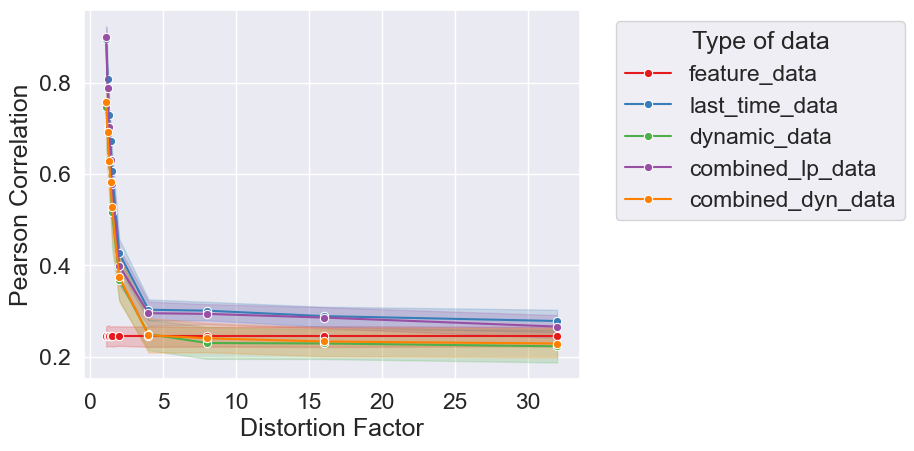

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from models.utils.config_manager import save_figure

sns.set_context("talk")
sns.set_style("whitegrid")
sns.set(font="Arial", font_scale=1.5)
sns.lineplot(data=all_results_df, x='Distortion Factor', y='Pearson Correlation', hue='Feature Data', palette='Set1', marker='o')
# 90 degree rotation of the x-axis labels
# legend to the right
plt.legend(title='Type of data', bbox_to_anchor=(1.05, 1), loc='upper left')
save_figure(notebook_config, plt.gcf(), "distortion_line_plot", verbose=1)
plt.show()

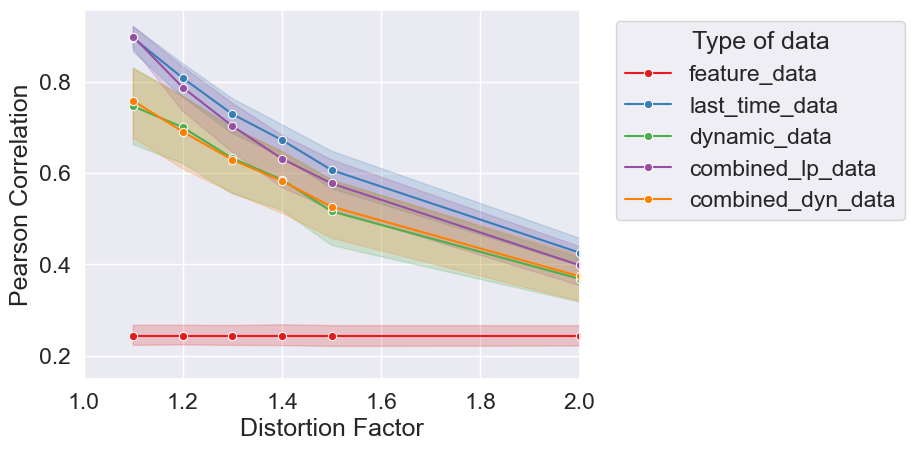

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set(font="Arial", font_scale=1.5)
sns.lineplot(data=all_results_df, x='Distortion Factor', y='Pearson Correlation', hue='Feature Data', palette='Set1', marker='o')
# 90 degree rotation of the x-axis labels
# legend to the right
plt.legend(title='Type of data', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(1, 2)  # Restrict x-axis to range 1-5
save_figure(notebook_config, plt.gcf(), "zoomed_distortion_line_plot", verbose=1)
plt.show()